In [1]:
! export PYTHONPATH="$PYTHONPATH:$HOME/generic_implementation/POISEVAE"

In [2]:
import os
import numpy as np
import torch
import scipy.io as sio
import matplotlib.pyplot as plt
import random

In [3]:
def _rand_match_on_idx(l1, idx1, l2, idx2, max_d=10000, dm=10):
# The code is adapted from https://github.com/iffsid/mmvae, the repository for the work
# Y. Shi, N. Siddharth, B. Paige and PHS. Torr.
# Variational Mixture-of-Experts Autoencoders for Multi-Modal Deep Generative Models.
# In Proceedings of the 33rd International Conference on Neural Information Processing Systems,
# Page 15718–15729, 2019
    """
    l*: sorted labels
    idx*: indices of sorted labels in original list
    """
    _idx1, _idx2 = [], []
    for l in l1.unique():  # assuming both have same idxs
        l_idx1, l_idx2 = idx1[l1 == l], idx2[l2 == l]
        n = min(l_idx1.size(0), l_idx2.size(0), max_d)
        l_idx1, l_idx2 = l_idx1[:n], l_idx2[:n]
        for _ in range(dm):
            _idx1.append(l_idx1[torch.randperm(n)])
            _idx2.append(l_idx2[torch.randperm(n)])
    return torch.cat(_idx1), torch.cat(_idx2)

def MNIST_SVHN_augment(MNIST_PATH, SVHN_PATH, max_d=10000, dm=20):
    """
    max_d: int, default 10000
        Maximum number of datapoints per class
    dm: int, default 20
        Data multiplier: random permutations to match
    """
    mnist = torch.load(MNIST_PATH)
    svhn = sio.loadmat(SVHN_PATH)

    svhn['y'] = torch.LongTensor(svhn['y'].squeeze().astype(int)) % 10
    
    mnist_l, mnist_li = mnist[1].sort()
    svhn_l, svhn_li = svhn['y'].sort()
    idx_mnist, idx_svhn = _rand_match_on_idx(mnist_l, mnist_li, svhn_l, svhn_li, max_d=max_d, dm=dm)
    torch.save(idx_mnist, os.path.join(os.path.dirname(MNIST_PATH), 'ms-mnist-idx.pt'))
    torch.save(idx_svhn, os.path.join(os.path.dirname(SVHN_PATH), 'ms-svhn-idx.pt'))
    
    return idx_mnist, idx_svhn

In [4]:
class MNIST_SVHN(torch.utils.data.Dataset):
    def __init__(self, mnist_pt_path, svhn_mat_path, sampler_mnist=None, sampler_svhn=None):
        self.mnist_pt_path, self.svhn_mat_path = mnist_pt_path, svhn_mat_path
        self.sampler_mnist, self.sampler_svhn = sampler_mnist, sampler_svhn
            
        # Load the pt for MNIST and mat for SVHN 
        self.mnist_data, self.mnist_targets = torch.load(self.mnist_pt_path)
        
        # Reading the SVHN data
        svhn_mat_info = sio.loadmat(self.svhn_mat_path)
        self.svhn_data = svhn_mat_info['X']
        # the svhn dataset assigns the class label "10" to the digit 0
        self.svhn_targets = svhn_mat_info['y'].astype(np.int64).squeeze() % 10
        self.svhn_data = np.transpose(self.svhn_data, (3, 2, 0, 1))
        
        if sampler_mnist is None:
            # Now we have the svhn data and the SVHN Labels, for each index get the classes
            self.svhn_target_idx_mapping = self._process_svhn_labels()
            self.__len__ = lambda: len(self.mnist_data)
        else:
            self.__len__ = lambda: len(self.sampler_mnist)
        
    def _process_svhn_labels(self):
        numbers_dict = {0: [], 1: [], 2: [], 3:[], 4:[], 5:[], 6:[], 7: [], 8:[], 9:[]}
        for i in range(len(self.svhn_targets)):
            svhn_target = self.svhn_targets[i]
            numbers_dict[svhn_target].append(i)
        return numbers_dict
        
    def __len__(self):
        if self.sampler_mnist is None:
            return len(self.mnist_data)
        else:
            return len(self.sampler_mnist)
        
    def __getitem__(self, index):
        if self.sampler_mnist is None:
            mnist_img, mnist_target = self.mnist_data[index], int(self.mnist_targets[index])
            indices_list = self.svhn_target_idx_mapping[mnist_target]

            # Randomly pick an index from the indices list
            idx = random.choice(indices_list)
            svhn_img = self.svhn_data[idx]
            svhn_target = self.svhn_targets[idx]
        else:
            mnist_img = self.mnist_data[self.sampler_mnist[index]]
            mnist_target = int(self.mnist_targets[self.sampler_mnist[index]])

            svhn_img = self.svhn_data[self.sampler_svhn[index]]
            svhn_target = int(self.svhn_targets[self.sampler_svhn[index]])

        return mnist_img.view(-1)/255, svhn_img/255, mnist_target, svhn_target

In [5]:
MNIST_PATH = 'MNIST/MNIST/processed/%s.pt'
SVHN_PATH = 'SVHN/%s_32x32.mat'
idx_mnist_train, idx_svhn_train = MNIST_SVHN_augment(MNIST_PATH % 'train', SVHN_PATH % 'train', max_d=10000, dm=20)
idx_mnist_test, idx_svhn_test = MNIST_SVHN_augment(MNIST_PATH % 'test', SVHN_PATH % 'test', max_d=10000, dm=20)

In [6]:
joint_dataset_train = MNIST_SVHN(MNIST_PATH % 'train', SVHN_PATH % 'train', idx_mnist_train, idx_svhn_train)
joint_dataset_test = MNIST_SVHN(MNIST_PATH % 'test', SVHN_PATH % 'test', idx_mnist_test, idx_svhn_test)
len(joint_dataset_train), len(joint_dataset_test)

(1121360, 200000)

In [7]:
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=128, shuffle=True)

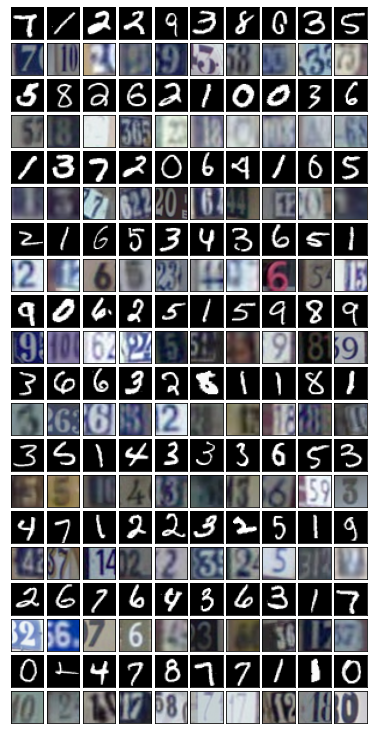

In [8]:
for im1, im2, l1, l2 in train_loader:
    break
    
fig, ax = plt.subplots(nrows=20, ncols=10, figsize=(5, 10))
for i in range(10):
    for j in range(10):
        ax[i*2, j].imshow(im1[i*10+j].cpu().numpy().reshape(28, 28), cmap='gray')
        ax[i*2+1, j].imshow(im2[i*10+j].cpu().numpy().transpose(1, 2, 0))
        ax[i*2+1, j].set_xticks([])
        ax[i*2, j].set_yticks([])
        ax[i*2+1, j].set_yticks([])
        ax[i*2, j].set_xticks([])
fig.tight_layout(pad=0)

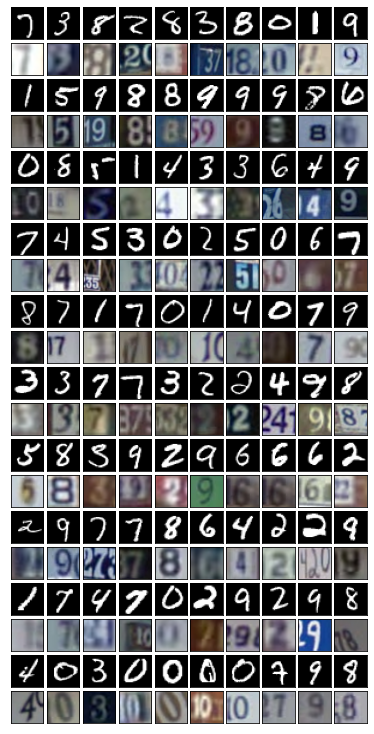

In [9]:
for im1, im2, l1, l2 in test_loader:
    break
    
fig, ax = plt.subplots(nrows=20, ncols=10, figsize=(5, 10))
for i in range(10):
    for j in range(10):
        ax[i*2, j].imshow(im1[i*10+j].cpu().numpy().reshape(28, 28), cmap='gray')
        ax[i*2+1, j].imshow(im2[i*10+j].cpu().numpy().transpose(1, 2, 0))
        ax[i*2+1, j].set_xticks([])
        ax[i*2, j].set_yticks([])
        ax[i*2+1, j].set_yticks([])
        ax[i*2, j].set_xticks([])
fig.tight_layout(pad=0)

## Without Augmentation

In [10]:
joint_dataset_train = MNIST_SVHN(MNIST_PATH % 'train', SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(MNIST_PATH % 'test', SVHN_PATH % 'test')
len(joint_dataset_train), len(joint_dataset_test)

(60000, 10000)

In [11]:
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=128, shuffle=True)

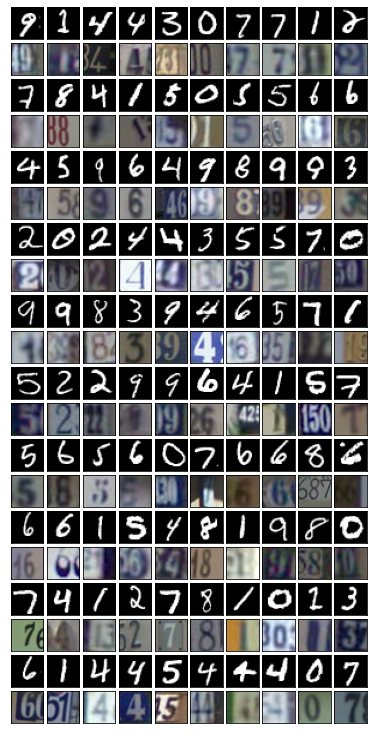

In [12]:
for im1, im2, l1, l2 in train_loader:
    break
    
fig, ax = plt.subplots(nrows=20, ncols=10, figsize=(5, 10))
for i in range(10):
    for j in range(10):
        ax[i*2, j].imshow(im1[i*10+j].cpu().numpy().reshape(28, 28), cmap='gray')
        ax[i*2+1, j].imshow(im2[i*10+j].cpu().numpy().transpose(1, 2, 0))
        ax[i*2+1, j].set_xticks([])
        ax[i*2, j].set_yticks([])
        ax[i*2+1, j].set_yticks([])
        ax[i*2, j].set_xticks([])
fig.tight_layout(pad=0)

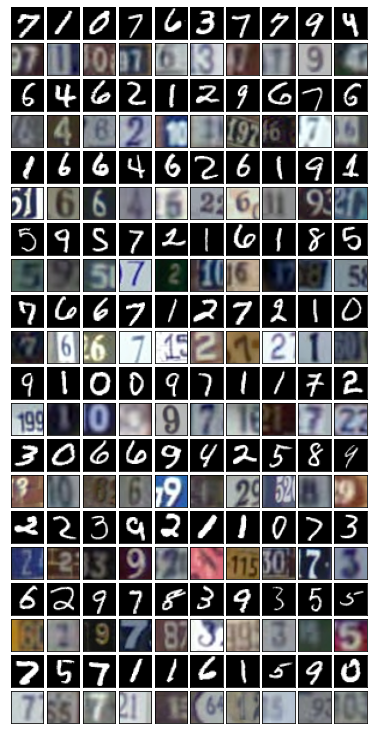

In [13]:
for im1, im2, l1, l2 in test_loader:
    break
    
fig, ax = plt.subplots(nrows=20, ncols=10, figsize=(5, 10))
for i in range(10):
    for j in range(10):
        ax[i*2, j].imshow(im1[i*10+j].cpu().numpy().reshape(28, 28), cmap='gray')
        ax[i*2+1, j].imshow(im2[i*10+j].cpu().numpy().transpose(1, 2, 0))
        ax[i*2+1, j].set_xticks([])
        ax[i*2, j].set_yticks([])
        ax[i*2+1, j].set_yticks([])
        ax[i*2, j].set_xticks([])
fig.tight_layout(pad=0)